In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import os
# from tqdm import tqdm_notebook as tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from dataset_utils import split_dataset_by_brand, split_dataset, reset_index
from sklearn.preprocessing import LabelEncoder


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda


In [5]:
import pandas as pd
dataset = pd.read_csv('./reg_data.csv')
dataset = dataset[dataset['price'].str.replace('.','',1).str.isdigit() == True]
dataset['price'] = dataset['price'].astype('float')

In [6]:
dataset.price.dtype


dtype('float64')

In [7]:
train,val,test = split_dataset(split_dataset_by_brand(dataset))
train_d = reset_index(train.sample(frac=1))
val_d = reset_index(val.sample(frac=1))
test_d = reset_index(test.sample(frac=1))

242 272 303
244 274 305
236 265 296
241 271 302
240 270 301
240 270 300
241 271 302
233 262 292
241 271 302
241 271 302
242 272 303
244 274 305


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.CenterCrop((200, 200)),
        transforms.RandomRotation(degrees=(-90, 90)),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.CenterCrop((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
class Watch_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'img'])
        image = Image.open(img_name).convert('RGB')
        #image = image.convert('RGB')
#         image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'price'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [10]:
train = Watch_Dataset(train_d,'./scraper/images',data_transforms['train'])
val = Watch_Dataset(val_d,'./scraper/images',data_transforms['val'])
test = Watch_Dataset(test_d,'./scraper/images',data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train, batch_size=20)
validation_loader = torch.utils.data.DataLoader(val, batch_size=20)
test_loader = torch.utils.data.DataLoader(test, batch_size=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


325.0
44996.0
229.0
5200.0
33673.0


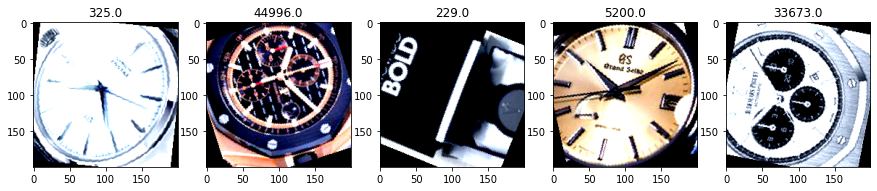

In [12]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

dataiter = iter(train_loader)
images, labels = dataiter.next()
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
#         print(i,images[i])
        image, label = images[i], labels[i]
        print(label.item())
        ax.set(title = f"{label}") # add label
        ax.imshow(img_display(image)) # add image

In [14]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(512, 1)
)
model = model.to(device)

In [15]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20
valid_loss_min = np.Inf
val_loss = []
train_loss = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
   
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        target_ = target_.type(torch.long)
        data_, target_ = data_.to(device), target_.to(device)# on GPU
#         print(type(data_),type(target_))
#         data_ = data_.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
#         print(type(outputs),type(target_))
#         target_ = target_.type(torch.long)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}')
    batch_loss = 0
   
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            target_t = target_t.type(torch.long)
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
#             target_t = target_t.type(torch.long)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss <= valid_loss_min
        print(f'min_val:{valid_loss_min}, validation loss: {np.mean(val_loss):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
#             torch.save(model.state_dict(), 'resnet18_pretr_softmax.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1



c:\users\acklozor\anaconda3\envs\ml\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Found dtype Long but expected Float
Exception raised from compute_types at ..\aten\src\ATen\native\TensorIterator.cpp:183 (most recent call first):
00007FFBC1CE75A200007FFBC1CE7540 c10.dll!c10::Error::Error [<unknown file> @ <unknown line number>]
00007FFB83BDEEBE00007FFB83BDE570 torch_cpu.dll!at::TensorIterator::compute_types [<unknown file> @ <unknown line number>]
00007FFB83BDD1B900007FFB83BDD140 torch_cpu.dll!at::TensorIterator::build [<unknown file> @ <unknown line number>]
00007FFB83BDC25D00007FFB83BDC1A0 torch_cpu.dll!at::TensorIterator::TensorIterator [<unknown file> @ <unknown line number>]
00007FFB83ADB9AA00007FFB83ADB8B0 torch_cpu.dll!at::native::mse_loss_backward_out [<unknown file> @ <unknown line number>]
00007FFB5C601D8700007FFB5C59E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFB83E02F0E00007FFB83DF8FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFB83E30C4900007FFB83E30BE0 torch_cpu.dll!at::mse_loss_backward_out [<unknown file> @ <unknown line number>]
00007FFB83ADB87800007FFB83ADB810 torch_cpu.dll!at::native::mse_loss_backward [<unknown file> @ <unknown line number>]
00007FFB5C601CA700007FFB5C59E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFB5C5F1A6800007FFB5C59E0A0 torch_cuda.dll!at::native::set_storage_cuda_ [<unknown file> @ <unknown line number>]
00007FFB83DFD85600007FFB83DF8FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFB83E30B6E00007FFB83E30B00 torch_cpu.dll!at::mse_loss_backward [<unknown file> @ <unknown line number>]
00007FFB850B373200007FFB8509E010 torch_cpu.dll!torch::autograd::GraphRoot::apply [<unknown file> @ <unknown line number>]
00007FFB83990B2800007FFB83986470 torch_cpu.dll!torch::nn::functional::BatchNormFuncOptions::~BatchNormFuncOptions [<unknown file> @ <unknown line number>]
00007FFB83DFD85600007FFB83DF8FA0 torch_cpu.dll!at::bucketize_out [<unknown file> @ <unknown line number>]
00007FFB83E30B6E00007FFB83E30B00 torch_cpu.dll!at::mse_loss_backward [<unknown file> @ <unknown line number>]
00007FFB850021FC00007FFB850020D0 torch_cpu.dll!torch::autograd::generated::MseLossBackward::apply [<unknown file> @ <unknown line number>]
00007FFB84FD7E9100007FFB84FD7B50 torch_cpu.dll!torch::autograd::Node::operator() [<unknown file> @ <unknown line number>]
00007FFB8553F9BA00007FFB8553F300 torch_cpu.dll!torch::autograd::Engine::add_thread_pool_task [<unknown file> @ <unknown line number>]
00007FFB855403AD00007FFB8553FFD0 torch_cpu.dll!torch::autograd::Engine::evaluate_function [<unknown file> @ <unknown line number>]
00007FFB85544FE200007FFB85544CA0 torch_cpu.dll!torch::autograd::Engine::thread_main [<unknown file> @ <unknown line number>]
00007FFB85544C4100007FFB85544BC0 torch_cpu.dll!torch::autograd::Engine::thread_init [<unknown file> @ <unknown line number>]
00007FFB279C08F700007FFB27999F80 torch_python.dll!THPShortStorage_New [<unknown file> @ <unknown line number>]
00007FFB8553BF1400007FFB8553B780 torch_cpu.dll!torch::autograd::Engine::get_base_engine [<unknown file> @ <unknown line number>]
00007FFBDEBB0E8200007FFBDEBB0D40 ucrtbase.dll!beginthreadex [<unknown file> @ <unknown line number>]
00007FFBDF777BD400007FFBDF777BC0 KERNEL32.DLL!BaseThreadInitThunk [<unknown file> @ <unknown line number>]
00007FFBE11CCE5100007FFBE11CCE30 ntdll.dll!RtlUserThreadStart [<unknown file> @ <unknown line number>]
